#### обновление библиотек, при выполнении кода в тетрадке, сначала выполнить следующую ячейку затем перезапустить ядро

In [1]:
!pip install seaborn --upgrade
!pip install xgboost --upgrade
!pip install -U scikit-learn
!pip install pandas --upgrade
!pip install numpy --upgrade

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 1.8.0 requires Cython<0.29.18,>=0.29, but you have cython 0.29.23 which is incompatible.


  Using cached pandas-1.3.3-cp38-cp38-win_amd64.whl (10.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 1.8.0 requires Cython<0.29.18,>=0.29, but you have cython 0.29.23 which is incompatible.


## Вводная

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

#### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

#### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Импорт библиотек

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style="white")
import scipy.stats as stats
from scipy.stats import chi2_contingency, chi2

#Обучение и тестирование моделей
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report, confusion_matrix, accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

## Загрузка и предобработка данных

In [95]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    contract = pd.read_csv('datasets/final_provider/contract.csv')
    internet = pd.read_csv('datasets/final_provider/internet.csv')
    personal = pd.read_csv('datasets/final_provider/personal.csv')
    phone = pd.read_csv('datasets/final_provider/phone.csv')

In [96]:
display(contract.head())
display(contract.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

In [97]:
display(internet.head())
display(internet.info())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [98]:
display(personal.head())
display(personal.info())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

In [99]:
display(phone.head())
display(phone.info())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Объединяем данные в одну таблицу, взяв за основу информацию о контрактах и присоединив к ней остальные.

In [100]:
df = (contract.merge(internet, on = 'customerID', how = 'left')
      .merge(phone, on = 'customerID', how = 'left')
      .merge(personal, on = 'customerID', how = 'left'))

In [101]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  MultipleLines     6361 non-null   object 
 16  gender            7043 non-null   object 


Столбец TotalCharges по логике должен иметь тип float64

In [103]:
df.TotalCharges.value_counts().sort_values()

7674.55     1
155.8       1
5293.95     1
4759.85     1
6148.45     1
           ..
19.9        8
20.05       8
19.75       9
20.2       11
           11
Name: TotalCharges, Length: 6531, dtype: int64

Есть 11 пропусков, которые не идентифицировались как NaN, это менее 1% от имеющихся данных и строки с ними скорее всего можно удалить

In [104]:
df[df.TotalCharges == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,NaN,Female,0,Yes,Yes
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,No,Female,0,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Male,0,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,Female,0,Yes,Yes
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,Yes,Yes
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Male,0,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Female,0,Yes,Yes
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Male,0,Yes,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Female,0,Yes,Yes


в данном случае это клиенты, начавшие пользоваться услугами в день, когда скорее всего были извлечены данные. Оплата возможно еще не прошла

In [105]:
df = df[df.TotalCharges != ' ']

In [106]:
df.TotalCharges = df.TotalCharges.astype('float64')

Пропуски в совокупной таблице означают отсутствие услуги и их можно заполнить соответственно :No
в столбец MultipleLines добавляем обозначение No service - чтобы отметить клиентов, не пользующихся телефоном

In [107]:
df.MultipleLines.fillna('No service', inplace=True)       
df.fillna('No', inplace=True)

Столбцы с бинарными значениями Yes/No Male/Female кодируем 1/0

In [108]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents'],
      dtype='object')

In [109]:
for col in ['PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Partner', 'Dependents']:
    df[col]=df[col].map({'Yes': 1, 'No':0})
df.gender = df.gender.map({'Male': 1, 'Female':0})

столбец CustomerID больше не нужен

In [110]:
df = df.drop(columns='customerID')

Создадим отдельный столбец Churned, который будет являться целевым признаком при обучении модели

In [111]:
df['Churned'] = df.EndDate.apply(lambda x: np.where(x == 'No', 0, 1))

Добавим столбец с количеством месяцев, которые действовал/действует контракт. Предварительно, заменим No в столбце EndDate на дату актуальности информации 01-02-2020

In [112]:
df.EndDate = df.EndDate.apply(lambda x: np.where(x == 'No', '2020-02-01 00:00:00', x))

In [113]:
df.BeginDate = pd.to_datetime(df.BeginDate)
df.EndDate = pd.to_datetime(df.EndDate)

In [114]:
df['lifetime'] = ((df.EndDate - df.BeginDate)/np.timedelta64(1, 'D')).astype(int)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   datetime64[ns]
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   int64         
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   InternetService   7032 non-null   object        
 8   OnlineSecurity    7032 non-null   int64         
 9   OnlineBackup      7032 non-null   int64         
 10  DeviceProtection  7032 non-null   int64         
 11  TechSupport       7032 non-null   int64         
 12  StreamingTV       7032 non-null   int64         
 13  StreamingMovies   7032 non-null   int64         
 14  MultipleLines     7032 n

In [116]:
numeric_cols = ['lifetime', 'MonthlyCharges', 'TotalCharges']
cat_cols = ['Type',
            'PaperlessBilling',
            'PaymentMethod',
            'InternetService',
            'OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV',
            'StreamingMovies',
            'MultipleLines', 
            'gender',
            'SeniorCitizen',
            'Partner',
            'Dependents']
target_col = 'Churned'

## Анализ данных

In [117]:
df.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,Churned,lifetime
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.592719,64.798208,2283.300441,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.504693,0.162400,0.482509,0.298493,0.265785,987.538538
std,0.491363,30.085974,2266.771362,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.500014,0.368844,0.499729,0.457629,0.441782,747.153663
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,0.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,275.000000
50%,1.000000,70.350000,1397.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,883.000000
75%,1.000000,89.862500,3794.737500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1676.000000
max,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2191.000000


### Cоотношение ушедших и активных клиентов

Text(18.21, 0.5, 'Ушедшие / Активные')

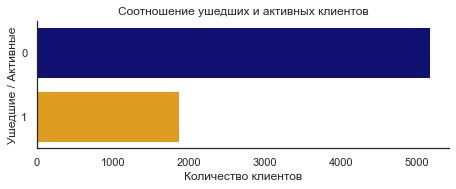

In [118]:
ax = sns.catplot(y="Churned", kind="count", data=df, height=2.6, aspect=2.5, orient='h', palette=['navy', 'orange'])
plt.title('Соотношение ушедших и активных клиентов')
plt.xlabel('Количество клиентов')
plt.ylabel('Ушедшие / Активные')

Отношение ушедших к активным примерно 1 к 3, то есть присутствует дисбаланс классов, который нужно будет учесть на этапе обучения модели

### Анализ численных признаков
Имеем три численных признака: ежемесячные списания, общая сумма списаний и количество месяцев пользования услугами
Проверим как распределены их значения для активных и ушедших клиентов

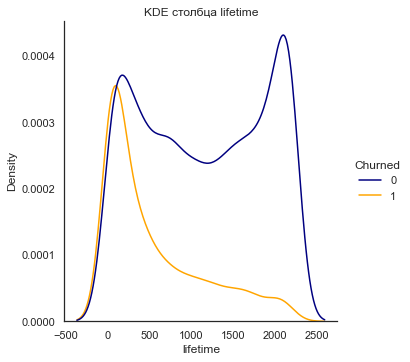

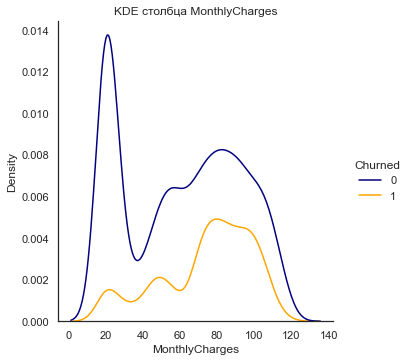

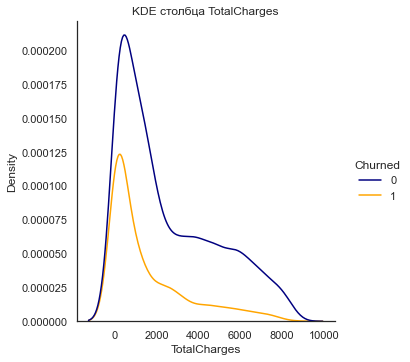

In [119]:
for feature in numeric_cols:    
    sns.displot(data = df, x=feature, hue='Churned', kind='kde', palette=['navy', 'orange'])
    plt.title("KDE столбца {}".format(feature))
    plt.show()


Из графиков видно, что вероятность потерять клиента наиболее высока в первые месяцы и в дальнейшем падает, и что вероятность ухода растёт с возрастанием стоимости услуг

### Анализ категориальных признаков

Далее проверим доли активных и ушедших клиентов относительно бинарных категориальных признаков (пол, наличие услуг и т.д.)

In [120]:
def cat_ratio_plot(data, cat_features, target, orient='h', axis_name = 'Доля клиентов'):
    ratios = pd.DataFrame()
    ''' ав'''
    a = len(cat_features)
    b = 1
    count = 1

    fig = plt.figure(figsize=(14,3*len(cat_features)))
    for feature in cat_features:
        plt.subplot(a, b, count)
        g = data.groupby(feature)[target].value_counts().to_frame()
        g = g.rename({target: axis_name}, axis=1).reset_index()
        g[axis_name] = g[axis_name]/len(data)
        if orient == 'v':
            ax = sns.barplot(x=feature, y= axis_name, hue=target, data=g, orient=orient,
                             palette=['navy', 'orange'])
            #ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
        else:
            ax = sns.barplot(x= axis_name, y=feature, hue=target, data=g, orient=orient
                         ,palette=['navy', 'orange'])
            #ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
        ax.plot()
        plt.title(f'Доля активных и ушедших клиентов по признаку {feature}')
        count+=1
    plt.tight_layout()
    plt.show()

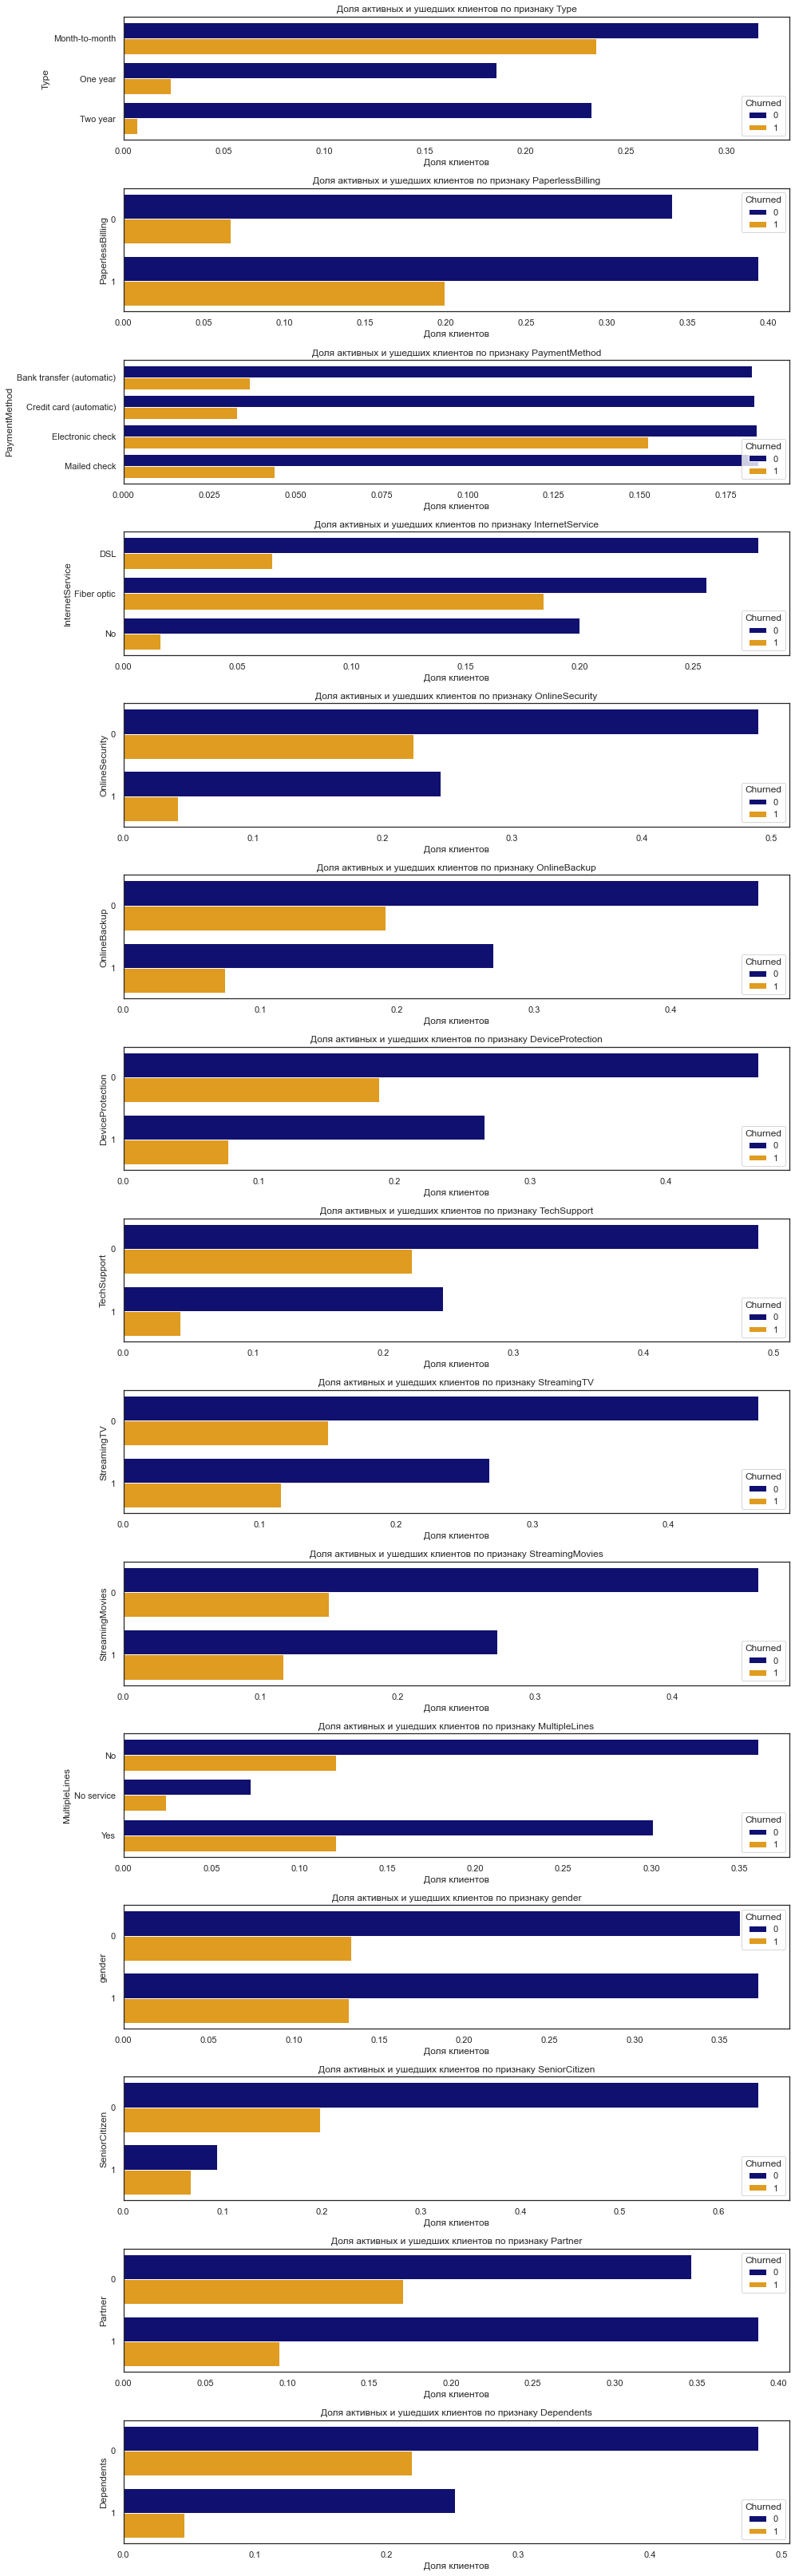

In [121]:
cat_ratio_plot(df, cat_cols, target_col)

- 'gender'- Доли ушедших мужчин и женщин примерно одинаковы
- 'SeniorCitizen' - Пожилые люди более склонны прекращать пользоваться услугами, при этом их доля относительно общего количества клиентов мала
- 'Partner' - Среди одиноких людей доля уходящих больше
- 'Dependents' - Среди людей, не имеющих иждевенцев, доля уходящих больше
- 'PaperlessBilling' - чаще уходят пользователи, оплачивающие электронно
- 'OnlineSecurity'- более склонны уходить клиенты без услуги
- 'OnlineBackup'- более склонны уходить клиенты без услуги
- 'DeviceProtection' - более склонны уходить клиенты без услуги
- 'TechSupport' - более склонны уходить клиенты без услуги
- 'StreamingTV' - более склонны уходить пользователи услуги
- 'StreamingMovies' - более склонны уходить пользователи услуги





Для категориальных признаков с несколькими значениями картина следующая:
- 'Type' - Больше всего уходят клиенты с ежемесячной тарификацией, почти не уходят клиенты с двухлетними контрактами
- 'PaymentMethod' - Больше всего уходят клиенты, со способом оплаты - электронный чек, и этот метод чаще всего предпочитают
- 'MultipleLines' - более склонны уходить пользователи услуги, но разрыв не выглядит значительным, доля клиентов без телефонных услуг значительно меньше клиентов без интернет-услуг
- 'InternetService' - Больше всего ушедших клиентов с оптоволоконным подключением к интернету, доля ушедших клиентов, не имеющих подключения к интернету, крайне мала

Категориальные признаки можно также проверить хи-квадрат тестом

In [122]:
for column in cat_cols:
    print(f'Столбец {column}\n\n')
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df[target_col], df[column]))

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('вероятность=%.3f, крит. значение=%.3f, статистика=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Есть зависимость (можно отвергнуть H0)')
    else:
        print('Нет зависимости (нельзя отвергнуть H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('значимость=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Есть зависимость (можно отвергнуть H0)\n\n')
    else:
        print('Нет зависимости (нельзя отвергнуть H0)\n\n')

Столбец Type


вероятность=0.950, крит. значение=5.991, статистика=1179.546
Есть зависимость (можно отвергнуть H0)
значимость=0.050, p=0.000
Есть зависимость (можно отвергнуть H0)


Столбец PaperlessBilling


вероятность=0.950, крит. значение=3.841, статистика=256.875
Есть зависимость (можно отвергнуть H0)
значимость=0.050, p=0.000
Есть зависимость (можно отвергнуть H0)


Столбец PaymentMethod


вероятность=0.950, крит. значение=7.815, статистика=645.430
Есть зависимость (можно отвергнуть H0)
значимость=0.050, p=0.000
Есть зависимость (можно отвергнуть H0)


Столбец InternetService


вероятность=0.950, крит. значение=5.991, статистика=728.696
Есть зависимость (можно отвергнуть H0)
значимость=0.050, p=0.000
Есть зависимость (можно отвергнуть H0)


Столбец OnlineSecurity


вероятность=0.950, крит. значение=3.841, статистика=205.416
Есть зависимость (можно отвергнуть H0)
значимость=0.050, p=0.000
Есть зависимость (можно отвергнуть H0)


Столбец OnlineBackup


вероятность=0.950, крит. знач

## Обучение и тестирование моделей

Целевой показатель по заданию - ROC-AUC >= 0.85, вторичный показатель - Accuracy

### Проверка модели на адекватность

Имеем соотношение классов целевого признака 0.74 / 0.26

То есть, если предсказывать 0 во всех случаях, метрика accuracy будет равна 0.74, ROC-AUC - 0.5

### Обработка перед обучением модели

Кодируем оставшиеся категориальные признаки через OHE

In [123]:
df = pd.get_dummies(df, drop_first = True)

### *Доработки после кросс-валидации моделей

#### 1.Категоризация признаков


Распределение значений данного столбца имеет 3 ярко выраженных пика. Экспериментальным путём выявлено, что кластеризация числовых признаков, и использование номера кластера при обучении модели, улучшает результат

In [124]:
from sklearn.cluster import KMeans

<AxesSubplot:>

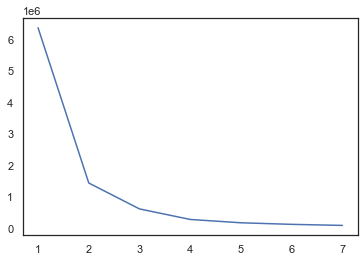

In [125]:
sns.lineplot(x=range(1, 8),
                 y=(KMeans(k, random_state=42).fit(df[['MonthlyCharges']].values.reshape(-1, 1)).inertia_
                    for k in range(1, 8)))

In [126]:
cluster_charges = KMeans(3, random_state = 42).fit_predict(df[['MonthlyCharges']])

In [127]:
df['cluster_charges'] = cluster_charges

### Отбор признаков, которые будут использоваться при обучении

In [136]:
df.columns

Index(['BeginDate', 'EndDate', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'Churned', 'lifetime',
       'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_No service', 'MultipleLines_Yes', 'cluster_charges'],
      dtype='object')

In [137]:
cat_cols_trimmed = ['PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies',
       'SeniorCitizen', 'Partner', 'Dependents',
       'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_No service', 'MultipleLines_Yes', 'cluster_charges']
num_cols_trimmed = ['lifetime']

In [138]:
feature_cols = cat_cols_trimmed + num_cols_trimmed

### Важность признаков
Для оценки важности признаков обучим модель случайного леса на всех данных и выведем аттрибут *feature_importances_*
оставшиеся категориальные признаки кодируем методом OHE

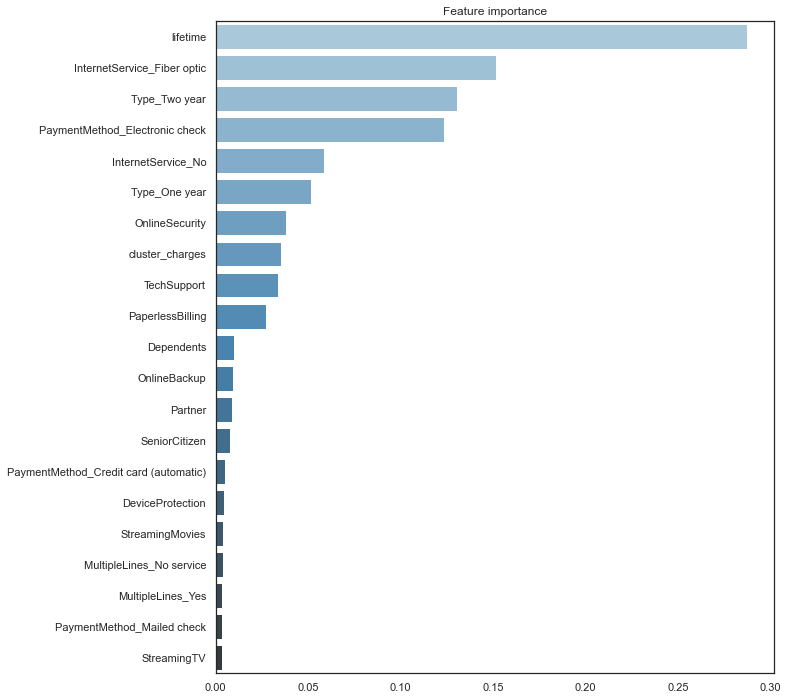

In [139]:
params = {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1000, 'max_depth': 4}
# One-hot encode
x, y = df[feature_cols], df['Churned']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

### Деление на обучающую и тестовую выборки

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols],
                                                    df[target_col],
                                                    test_size=0.25,
                                                    stratify=df[target_col],
                                                    random_state=42)

In [141]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_cols_trimmed])
X_train[num_cols_trimmed] = scaler.transform(X_train[num_cols_trimmed])
X_test[num_cols_trimmed] = scaler.transform(X_test[num_cols_trimmed])


### Обучение моделей

Проверены методом кросс-валидации с применением GridSearch модели:
- Logistic Regression
- Random Forest (ансамблевый метод)
- XGBClassifier (бустинг)

In [142]:
search_space = [
                {'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0, class_weight='balanced')],
                'classifier__n_estimators': [100, 250, 500],
                'classifier__max_depth': [4, 6, 8]},
                
                {'classifier': [LogisticRegression(class_weight='balanced', solver = 'saga')]},
                
                {'classifier': [XGBClassifier(eval_metric = 'auc')],
                 'classifier__n_estimators': [100, 250, 500],
                 'classifier__learning_rate': [0.05, 0.1, 0.5],
                 'classifier__max_depth': [4, 6, 8]}]
kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)

pipeline = Pipeline(steps = [['classifier', LogisticRegression()]
                                   ])
grid_search_common = GridSearchCV(estimator=pipeline,
                                 param_grid= search_space,
                                 scoring='roc_auc',
                                 cv=kfold,
                                 verbose = 0,
                                 
                                 n_jobs=-1)
best_model_common = grid_search_common.fit(X_train, y_train)

In [143]:
best_model_common.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
               gamma=None, gpu_id=None, importance_type='gain',
               interaction_constraints=None, learning_rate=0.1,
               max_delta_step=None, max_depth=4, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=500,
               n_jobs=None, num_parallel_tree=None, random_state=None,
               reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
               subsample=None, tree_method=None, validate_parameters=None,
               verbosity=None),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 4,
 'classifier__n_estimators': 500}

Лучшие 10 результатов

In [144]:
results = pd.DataFrame(best_model_common.cv_results_).sort_values(by='mean_test_score',
                                                                  ascending = False).reset_index(drop=True)


In [145]:
results[['param_classifier',
         'mean_test_score', 
         'std_test_score',
         'mean_fit_time',
         'mean_score_time',
         'rank_test_score']].head(20)

,param_classifier,mean_test_score,std_test_score,mean_fit_time,mean_score_time,rank_test_score
0,"XGBClassifier(base_score=None, booster=None, c...",0.926798,0.013724,4.381680,0.009973,1
1,"XGBClassifier(base_score=None, booster=None, c...",0.921442,0.012356,1.096667,0.009973,2
2,"XGBClassifier(base_score=None, booster=None, c...",0.921332,0.017065,6.709853,0.011370,3
3,"XGBClassifier(base_score=None, booster=None, c...",0.920750,0.018545,3.578429,0.008976,4
4,"XGBClassifier(base_score=None, booster=None, c...",0.919602,0.017489,6.628670,0.011369,5
5,"XGBClassifier(base_score=None, booster=None, c...",0.918708,0.012127,2.870721,0.008777,6
6,"XGBClassifier(base_score=None, booster=None, c...",0.914837,0.016785,2.143267,0.008976,7
7,"XGBClassifier(base_score=None, booster=None, c...",0.913923,0.016884,4.858405,0.011170,8
8,"XGBClassifier(base_score=None, booster=None, c...",0.913296,0.015684,4.630157,0.009973,9
9,"XGBClassifier(base_score=None, booster=None, c...",0.913028,0.012625,4.500961,0.009574,10


## Проверка модели на тестовой выборке

In [146]:
prediction = best_model_common.predict(X_test)

In [147]:
print('Значение roc_auc на тестовой выборке:',abs(best_model_common.score(X_test, y_test)))

Значение roc_auc на тестовой выборке: 0.9320704863351452


In [148]:
print('Значение Accuracy на тестовой выборке:', accuracy_score(y_test, prediction))

Значение Accuracy на тестовой выборке: 0.8816837315130831


In [149]:
prediction = best_model_common.predict(X_test)

In [150]:
prediction_prob = best_model_common.predict_proba(X_test)

Визуализация кривой ROC-AUC

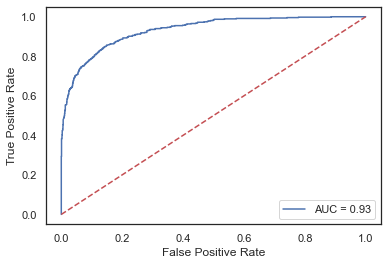

In [151]:
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.plot([0, 1], [0, 1],'r--')
plt.show()  

Матрица ошибок на тестовой выборке

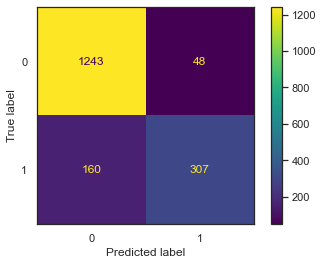

In [152]:
cm = confusion_matrix(y_test, prediction, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot() 

In [153]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1291
           1       0.86      0.66      0.75       467

    accuracy                           0.88      1758
   macro avg       0.88      0.81      0.83      1758
weighted avg       0.88      0.88      0.88      1758



## Итог

1. Разделение на обучающую и тестовую выборки выполнено в отношении 0.75 / 0.25
2. Dummy модель не была обучена, значения метрик, которые она даёт, в данном случае известны изначально
3. Проверено несколько моделей  с использованием кросс-валидации и перебора гиперпараметров. Использованы алгоритмы Логистической регрессии, Случайного леса, XGBoost.
- XGBoost показал лучший результат
- Обучение моделей выполнялось в несколько итераций, с удалением различных признаков из набора, пока не была преодолена отметка 0.85 на ROC-AUC
- На одной из итераций было решено преобразовать признак MonthlyCharges из числового в категориальный, что улучшило результат


